<a href="https://www.kaggle.com/code/victortrigo/u-net-brian-mri-segmentation?scriptVersionId=202176184" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# U-Net for Brian MRI Segmentation

Author: Víctor Trigo

Una anomalía cerebral es el crecimiento anormal de algún tipo de tejido en el cerebro, que eventualmente puede ser diagnosticado como un tumor. Estos pueden clasificarse según su célula en crecimiento o según su evolución (maligna benigna o incierta). 

Para la detección de una anomalía cerebral (o tumor cerebral) se utilizan sistemas de registro de imágenes médicas. La resonancia magnética (RM) es la técnica utilizada para extraer imágenes de este tipo de tumores. Las imágenes generadas por RM realza distintos tipos de información dependiendo del tipo de filtro utilizado, los filtros son: T1, T1 Gd, T2, T2-FLAIR. Estos filtros son medidas de tiempo basado en propiedades magnéticas de la materia, ayudan a realzar tejidos blandos y duros, materia gris y materia blanca según el tiempo en la interacción con el campo magnético generado por el escáner.

A continuacion se implementará un modelo U-Net para la segmentación de anomalías cerebrales en imagenes de resonancia magnética en filtro FLAIR.

## Libreries

In [1]:
!pip install --user tensorflow-addons==0.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00


In [2]:
import os 
from glob import glob
from tqdm import tqdm

import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, metrics
from tensorflow.keras import Input, Model
import tensorflow_addons as tfa

print(f"La version de Tensorflow es {tf.__version__}. Pueden Diferir algunas funciones!")

La version de Tensorflow es 2.6.4. Pueden Diferir algunas funciones!


## ETL

Crearemos una función llamada 'get_images_path' para obtener los directorios de las imágenes médicas y sus máscaras de segmentación. Una segunda función llamada 'read_images' utiliza los directorios obtenidos para cargar las imágenes médicas (con la función 'read_image') y las mascarás (con la función 'read_mask').

In [3]:
%%time
root = '../input/lgg-mri-segmentation/kaggle_3m'

def get_images_path():
    images = []
    labels = []
    for d in tqdm(os.listdir(root)):
        path = os.path.join(root, d)
        if os.path.isdir(path):
            iters = int(len(os.listdir(path))/2)
            for i in range(iters): 
                file = os.path.join(path, d) + '_' +str(i+1) + '.tif'
                mask = os.path.join(path, d) + '_' +str(i+1) + '_mask.tif'
                images.append(file)
                labels.append(mask)
    return images, labels

def read_images(paths, tipefile):
    images = []
    
    if tipefile == 'images':
        for f in tqdm(paths):
            img = read_image(f)
            images.append(img)    
    else:
        
        for f in tqdm(paths):
            img = read_mask(f)

            images.append(img)
    
    imgs1 = np.array(images)
    
    return imgs1
    
#  
def read_image(path):
    
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


In [4]:
imgs, labels = get_images_path()
images = read_images(imgs, 'images')
masks = read_images(labels, 'masks')

100%|██████████| 3929/3929 [00:44<00:00, 88.71it/s]


## Data Viz

Visualizaremos 5 imagenes al azar. El gráfico consta de la imágen médica junto a su respectivo mapa de segmentación.

In [5]:
def plot_image(image, mask):
    plt.figure(figsize=(7, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

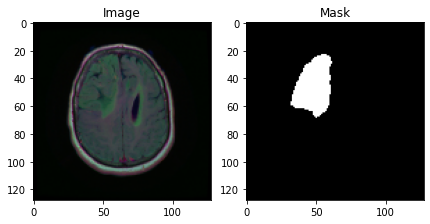

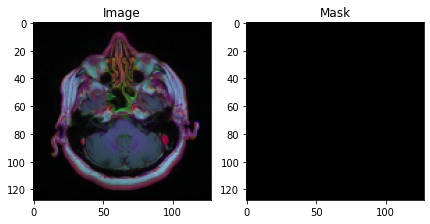

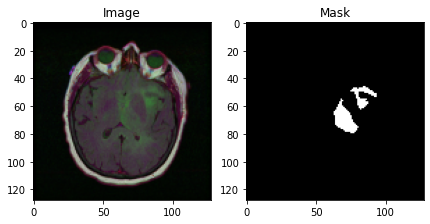

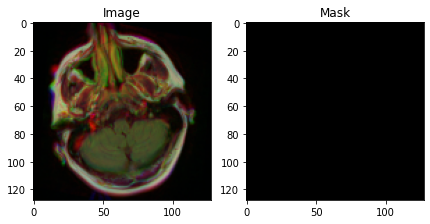

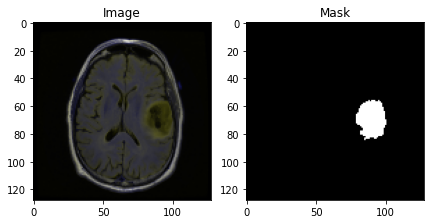

In [6]:
l = [random.randint(0,1000) for _ in range(5)]

for i in l:
    plot_image(images[i], masks[i])

Para obtener mejores resultados, debemos utilizar solo las imagenes en las que existan anomalias cerebrales. Podemos hacer esta distinción ya que la suma de los pixceles de las segmentaciones es $0$ si no existe segmentacion. Como resultado, tenemos 1.373 imágenes con anomalías cerebrales.

In [7]:
instance = []
for i in range(masks.shape[0]):
    
    if sum(sum(masks[i])) == 0:
        instance.append('neg')
    else:
        instance.append('pos')


In [8]:
count = 0
for i in range(len(instance)):
    if instance[i] == 'pos':
        count += 1
print('Número de casos positivos: ', count)

count = 0
for i in range(len(instance)):
    if instance[i] == 'neg':
        count += 1
print('Número de casos negativos: ', count)

Número de casos positivos:  1373
Número de casos negativos:  2556


In [9]:
n = images.shape[0]

images_pos = []
masks_pos = []

for i in range(n):
    if instance[i] == 'pos':
        images_pos.append(images[i])
        masks_pos.append(masks[i])
        
images_pos = np.array(images_pos)
masks_pos = np.array(masks_pos)

print('Número de imágenes ',images_pos.shape)
print('Número de mascaras ',masks_pos.shape)


Número de imágenes  (1373, 128, 128, 3)
Número de mascaras  (1373, 128, 128, 1)


Ahora visualizamos los casos positivos que utilizaremos.

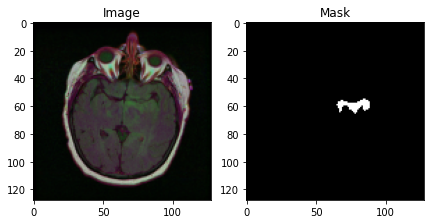

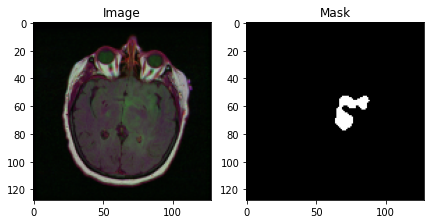

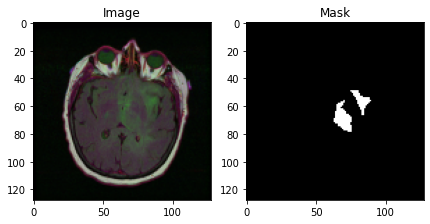

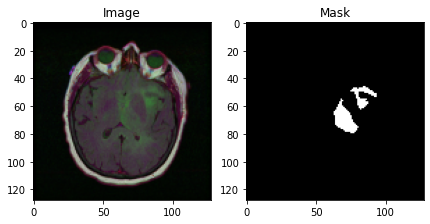

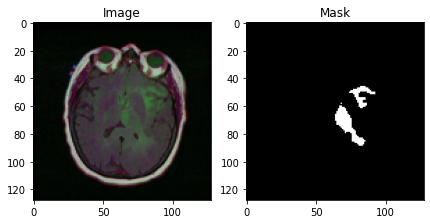

In [10]:
for i in range(5):
    plot_image(images_pos[i],masks_pos[i])

## Preparing Image for traning

Ya que tenemos las imagenes y mapas de segmentacion en diferentes listas, podemos hacer la separacion del conjunto de datos en entrenamiento, validacion y test. Cada observacion consiste en una imagen medica y un mapa de segmentacion. El conjunto de datos en entrenamiento contiene 1.029 observaciones, el conjunto de datos en validación contiene 172 observaciones, el conjunto de datos en test contiene 172 observaciones. Imágenes y mapas son de tamaño $128\times128$ px. Imágenes posee 3 canales y los mapas 1. 



In [11]:
X_train, X_test, y_train, y_test = train_test_split(images_pos, masks_pos, test_size = .25, random_state = 288)

In [12]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = .50, random_state = 288)

In [13]:
print('#'*10 + ' Images ' + '#'*10)
print('X_train shape: ',  X_train.shape)
print('X_val shape:   ',  X_val.shape)
print('X_test shape:  ',  X_test.shape)
print('\n')
print('#'*10 + ' Masks ' + '#'*10)
print('y_train shape: ',  y_train.shape)
print('y_val shape:   ',  y_val.shape)
print('y_test shape:  ',  y_test.shape)

########## Images ##########
X_train shape:  (1029, 128, 128, 3)
X_val shape:    (172, 128, 128, 3)
X_test shape:   (172, 128, 128, 3)


########## Masks ##########
y_train shape:  (1029, 128, 128, 1)
y_val shape:    (172, 128, 128, 1)
y_test shape:   (172, 128, 128, 1)


## U-Net

![](https://miro.medium.com/max/1200/1*f7YOaE4TWubwaFF7Z1fzNw.png)

U-Net es una estrategia de entrenamiento que consiste en construir un mapa de segmentacion utilizando distintos niveles de abstraccion de la informacion contenida en las imagenes de entrada. La arquitectura U-Net consiste en un codificador y un decodificador. El codificador es el encargado de extraer caracteristicas relevantes de las imágenes y el decodificador es el encargado de generar el mapa de segmentacion a partir de las caracteristicas extraidas en el codificador. 

Comenzamos creando un bloque convolucional, este consta de dos convoluciones 2D, con un tamaño de kernel de $3\times3$ y una activacion ReLu. Ademas, añadiendo una capa de batch normalization en cada convolucion.

In [14]:
def create_conv_block(input_tensor, num_filters):
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

Utilizando el bloque convolucional creado anteriormente construimos la arquitectura U-Net. Comenzando con el encoder, utilizando 4 bloques convolucionales se reduce el tamaño de la imagen de $150\times150$ a $16\times16$ pixeles.

In [15]:
def create_unet(input_shape, num_filters=16, dropout=0.1):
    # Encoder
    
    c1 = create_conv_block(input_shape, num_filters * 1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropout)(p1)

    c2 = create_conv_block(p1, num_filters * 2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropout)(p2)

    c3 = create_conv_block(p2, num_filters * 4)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropout)(p3)

    c4 = create_conv_block(p3, num_filters * 8)
    
    # Decoder
    
    u5 = tf.keras.layers.Convolution2DTranspose(num_filters*8, (3, 3), strides=(2, 2), padding='same')(c4)
    u5 = tf.keras.layers.concatenate([u5, c3])
    u5 = tf.keras.layers.Dropout(dropout)(u5)
    c5 = create_conv_block(u5, num_filters*4)
    
    u6 = tf.keras.layers.Convolution2DTranspose(num_filters*4, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c2])
    u6 = tf.keras.layers.Dropout(dropout)(u6)
    c6 = create_conv_block(u6, num_filters*2)
    
    u7 = tf.keras.layers.Convolution2DTranspose(num_filters*2, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c1])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = create_conv_block(u7, num_filters*1)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = tf.keras.Model(inputs = [input_shape], outputs = [output])
    
    return model 

In [16]:
inputs = tf.keras.layers.Input((128, 128, 3))
model = create_unet(inputs)

In [17]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

Graficar el modelo de la siguiente forma permite observar mejor el encoder y decoder y sus tamaños.

In [18]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                       save_weights_only=True,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)]

In [20]:
model_history = model.fit(X_train, 
                          y_train,
                          verbose = 1,
                          epochs = 100,
                          validation_data = (X_val, y_val),
                          callbacks = my_callbacks)

Epoch 1/100
33/33 [==============================] - 21s 151ms/step - loss: 0.4094 - accuracy: 0.8967 - val_loss: 5.4200 - val_accuracy: 0.5189
Epoch 2/100
33/33 [==============================] - 3s 101ms/step - loss: 0.2137 - accuracy: 0.9805 - val_loss: 0.6822 - val_accuracy: 0.8436
Epoch 3/100
33/33 [==============================] - 3s 101ms/step - loss: 0.1792 - accuracy: 0.9808 - val_loss: 2.5043 - val_accuracy: 0.6250
Epoch 4/100
33/33 [==============================] - 3s 101ms/step - loss: 0.1486 - accuracy: 0.9836 - val_loss: 0.1993 - val_accuracy: 0.9756
Epoch 5/100
33/33 [==============================] - 3s 101ms/step - loss: 0.1298 - accuracy: 0.9838 - val_loss: 0.1693 - val_accuracy: 0.9782
Epoch 6/100
33/33 [==============================] - 3s 101ms/step - loss: 0.1118 - accuracy: 0.9856 - val_loss: 0.1359 - val_accuracy: 0.9833
Epoch 7/100
33/33 [==============================] - 3s 102ms/step - loss: 0.0985 - accuracy: 0.9861 - val_loss: 0.1291 - val_accuracy: 0.984

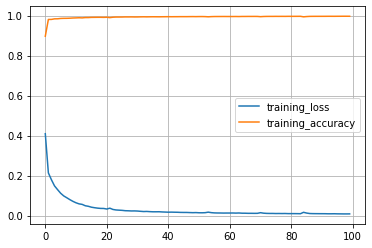

In [21]:
plt.plot(model_history.history['loss'], label='training_loss')
plt.plot(model_history.history['accuracy'], label='training_accuracy')
plt.legend()
plt.grid(True)

Ahora realizaremos las predicciones y luego transformar la mascara de segmentacion en un arreglo de $0$s y $1$s.

In [22]:
def predict_test_samples(X_test, y_test, model):
    test_images = np.array(X_test)

    predictions = model.predict(test_images)

    return predictions, test_images, y_test

In [23]:
def plot_images(test_image, predicted_maks, ground_truth):
    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image,cmap='gray')
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_maks,cmap='gray')
    plt.title('Predicted mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth,cmap='gray')
    plt.title('Ground truth mask')

In [24]:
predicted_masks, test_images, ground_truth_masks = predict_test_samples(X_test, y_test, model)

In [25]:
# Cambiar valores de mas mascaras a 0s y 1s
for i in range(predicted_masks.shape[0]):
    for j in range(predicted_masks.shape[1]):
        for k in range(predicted_masks.shape[2]):
            if predicted_masks[i,j,k] > .5:
                predicted_masks[i,j,k] = 1
            else:
                predicted_masks[i,j,k] = 0

In [26]:
def dice_coefficient(ground_truth_masks, predicted_masks, smooth=1):
    intersection = tf.reduce_sum(ground_truth_masks * predicted_masks, axis=[1, 2, 3])
    union = tf.reduce_sum(ground_truth_masks, axis=[1, 2, 3]) + tf.reduce_sum(predicted_masks, axis=[1, 2, 3])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

Dice = float(dice_coefficient(ground_truth_masks, predicted_masks, smooth=15))

print('Dice score', Dice)

Dice score 0.8417519927024841


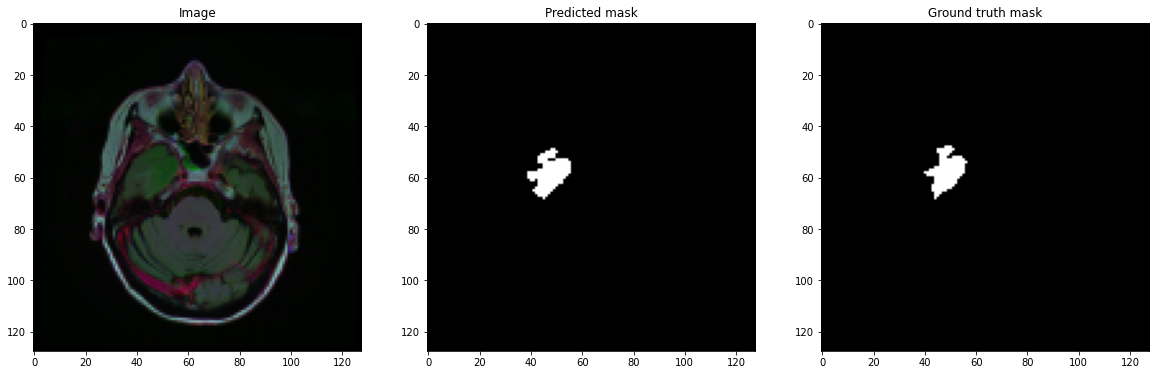

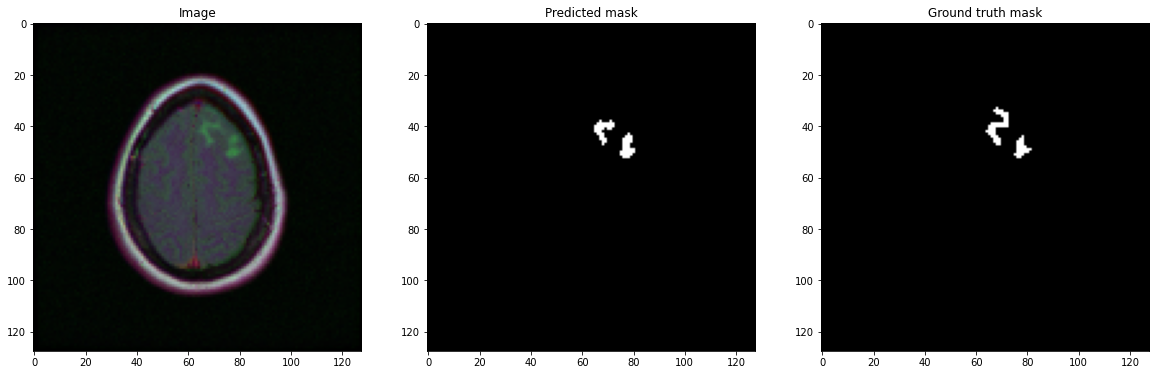

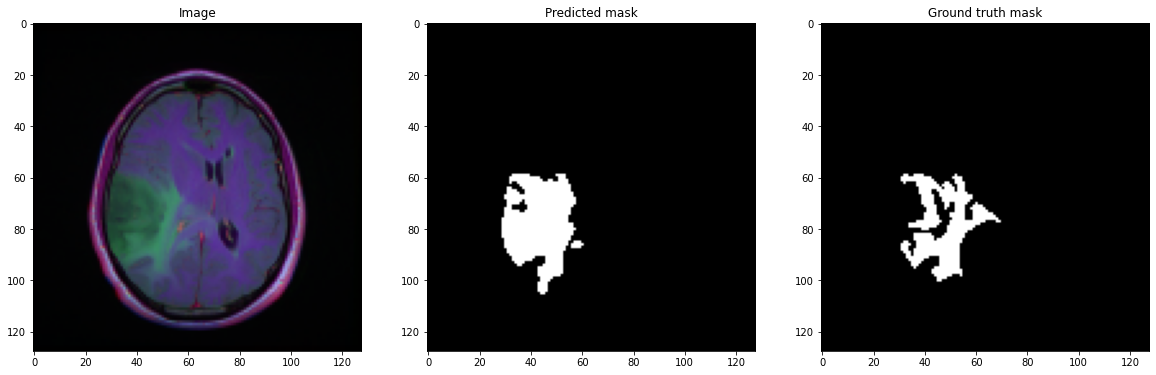

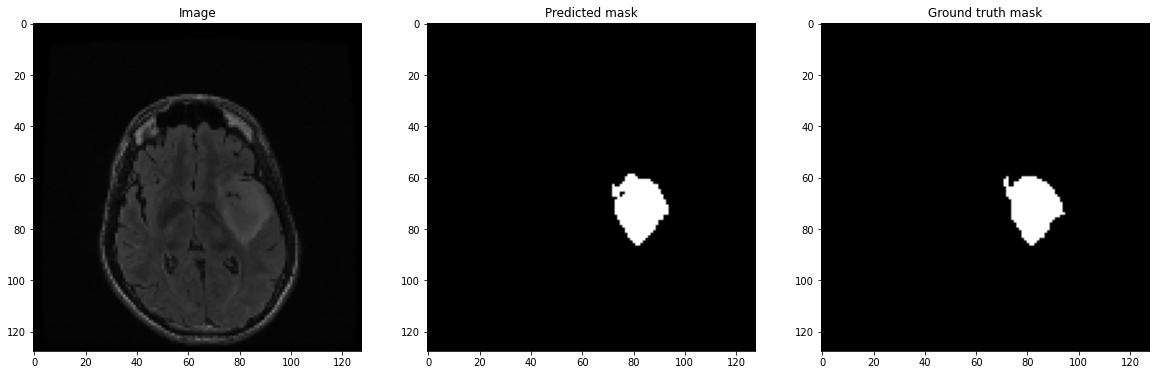

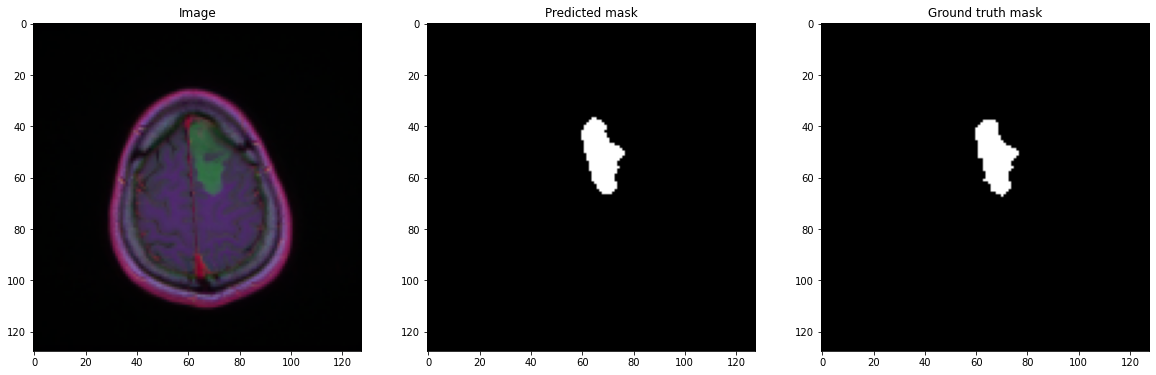

In [27]:
for idx in range(0, 5):
    plot_images(test_images[idx], predicted_masks[idx], ground_truth_masks[idx])

# Modelo II

In [28]:
print('#'*10 + ' Images ' + '#'*10)
print('X_train shape: ',  X_train.shape)
print('X_val shape:   ',  X_val.shape)
print('X_test shape:  ',  X_test.shape)

print('#'*10 + ' Masks ' + '#'*10)
print('y_train shape: ',  y_train.shape)
print('y_val shape:   ',  y_val.shape)
print('y_test shape:  ',  y_test.shape)

########## Images ##########
X_train shape:  (1029, 128, 128, 3)
X_val shape:    (172, 128, 128, 3)
X_test shape:   (172, 128, 128, 3)
########## Masks ##########
y_train shape:  (1029, 128, 128, 1)
y_val shape:    (172, 128, 128, 1)
y_test shape:   (172, 128, 128, 1)


In [29]:
imsize = [128,128,1]
batch_size = 12
n_epochs = 200
learning_rate = 1e-4
weight_decay= 1e-5

train_steps = X_train.shape[0] // batch_size
valid_steps = X_val.shape[0] // batch_size

In [30]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation=activations.swish)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [31]:
def create_unet(image_size, widths, block_depth):
    input_image = Input(shape=imsize)
    x = layers.Conv2D(widths[0], kernel_size=1)(input_image)
    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])
    
    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)
    
    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])
    
    out = layers.Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    
    return Model(inputs=input_image, outputs=out, name="UNet")

In [32]:
# Como funcion de costo, combinaremos un soft-dice score con la cross-entropia ponderada por un parametro beta

def combined_loss():
    def convert_to_logits(y_pred):
        #Como nuestro modelo entrega probabilidad, debemos retornarlo a logits
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1-tf.keras.backend.epsilon())
        return tf.math.log(y_pred / (1 - y_pred))
    
    def loss(y_true, y_pred, beta):
        y_pred = convert_to_logits(y_pred)
        pos_weight = beta / (1-beta)
        loss = tf.nn.weighted_cross_entropy_with_logits(
            logits=y_pred,
            labels=y_true,
            pos_weight=pos_weight,
        )
        return tf.reduce_mean(loss * (1-beta))
    
    def dice_loss(y_true, y_pred):
        numerator = 2. * tf.reduce_sum(tf.multiply(y_true, y_pred), axis=[1,2])
        denominator = tf.reduce_sum(tf.add(y_true, y_pred), axis=[1,2])
        x = tf.math.divide_no_nan(numerator, denominator)
        return tf.reduce_mean(1 - x)
    
    def combined(y_true, y_pred,):
        return 0.5*dice_loss(y_true, y_pred) + 0.5*loss(y_true, y_pred, 0.8)
    
    return combined

In [33]:
#Vamos a crear una Metrica como una clase
class DiceScore(metrics.Metric):
    def __init__(self, name="DiceScore", **kwargs):
        super(DiceScore, self).__init__(name=name, **kwargs)
        self.mean_dice = metrics.Mean(name="DiceScore_Tracker")
    
    def update_state(self, real, pred, sample_weight=None):
        numerator = 2. * tf.reduce_sum(tf.multiply(real, pred), axis=[1,2])
        denominator = tf.reduce_sum(tf.add(real, pred), axis=[1,2])
        x = tf.math.divide_no_nan(numerator, denominator)
        x = tf.reduce_mean(x)
        self.mean_dice.update_state(x)
    
    def result(self):
        return self.mean_dice.result()

    def reset_state(self):
        self.mean_dice.reset_state()

In [34]:
widths = [32, 64, 128, 256, 512]
block_depth = 2

In [35]:
initial_learning_rate = learning_rate
decay_steps =train_steps*int(0.85*n_epochs)
alpha = 1e-3


def decayed_learning_rate(step):
    step = np.minimum(step, decay_steps)
    cosine_decay = 0.5 * (1 + np.cos(np.pi * step / decay_steps))
    decayed = (1 - alpha) * cosine_decay + alpha
    return initial_learning_rate * decayed

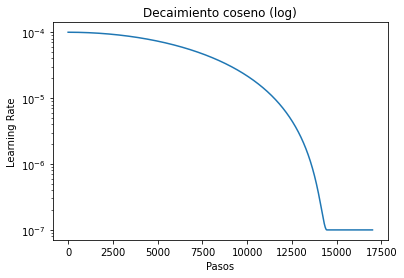

In [36]:
steps = np.arange(0, train_steps*n_epochs)
y = decayed_learning_rate(steps)

fig = plt.figure()
ax = fig.add_subplot()

ax.semilogy(steps, y)
ax.set(
    title='Decaimiento coseno (log)',
    xlabel='Pasos',
    ylabel='Learning Rate'
)
fig.show()

In [37]:

# En caso de querer usart un learning_rate estatico, comentar el scheduler y descomentar esta
# lr = learning_rate
lr = tf.keras.optimizers.schedules.CosineDecay(learning_rate, decay_steps=decay_steps, alpha=alpha)

# AdamW es una versión mas moderna del Algoritmo Adam, con decaimiento de pesos.
model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=lr,
        weight_decay=weight_decay,
    ),
    loss=combined_loss(),
    metrics=[DiceScore()],
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [38]:
# Early Stopping
cbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_DiceScore",
        patience=np.ceil(0.05*n_epochs).astype(int),
        mode="max",
        restore_best_weights=True,
    ),
]

In [39]:
model_history = model.fit(X_train, 
                          y_train,
                          validation_data = (X_val, y_val),
                          steps_per_epoch = train_steps,
                          validation_steps = valid_steps,
                          epochs = n_epochs,
                          callbacks = cbacks,
)

Epoch 1/200
85/85 [==============================] - 9s 63ms/step - loss: 0.0602 - DiceScore: 0.8831 - val_loss: 0.1023 - val_DiceScore: 0.8029
Epoch 2/200
85/85 [==============================] - 4s 46ms/step - loss: 0.0555 - DiceScore: 0.8935 - val_loss: 0.0975 - val_DiceScore: 0.8125
Epoch 3/200
85/85 [==============================] - 4s 47ms/step - loss: 0.0546 - DiceScore: 0.8954 - val_loss: 0.0970 - val_DiceScore: 0.8142
Epoch 4/200
85/85 [==============================] - 4s 47ms/step - loss: 0.0519 - DiceScore: 0.9010 - val_loss: 0.0965 - val_DiceScore: 0.8172
Epoch 5/200
85/85 [==============================] - 4s 47ms/step - loss: 0.0505 - DiceScore: 0.9040 - val_loss: 0.0960 - val_DiceScore: 0.8184
Epoch 6/200
85/85 [==============================] - 4s 47ms/step - loss: 0.0494 - DiceScore: 0.9067 - val_loss: 0.0935 - val_DiceScore: 0.8228
Epoch 7/200
85/85 [==============================] - 4s 47ms/step - loss: 0.0480 - DiceScore: 0.9091 - val_loss: 0.0928 - val_DiceScore:

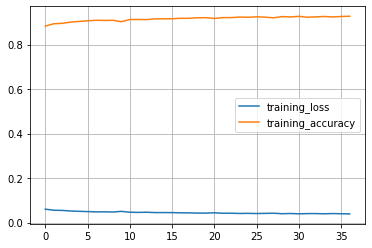

In [40]:
plt.plot(model_history.history['loss'], label='training_loss')
plt.plot(model_history.history['DiceScore'], label='training_accuracy')
plt.legend()
plt.grid(True)

In [41]:
def predict_test_samples(X_test, y_test, model):
    test_images = np.array(X_test)

    predictions = model.predict(test_images)

    return predictions, test_images, y_test

In [42]:
def plot_images(test_image, predicted_maks, ground_truth):
    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image,cmap='gray')
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_maks,cmap='gray')
    plt.title('Predicted mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth,cmap='gray')
    plt.title('Ground truth mask')

In [43]:
predicted_masks, test_images, ground_truth_masks = predict_test_samples(X_test, y_test, model)

In [44]:
np.unique(predicted_masks[0])

array([2.3468688e-06, 3.2004468e-06, 3.2909234e-06, ..., 9.9999869e-01,
       9.9999917e-01, 9.9999940e-01], dtype=float32)

In [45]:
# Cambiar valores de mas mascaras a 0s y 1s
for i in range(predicted_masks.shape[0]):
    for j in range(predicted_masks.shape[1]):
        for k in range(predicted_masks.shape[2]):
            if predicted_masks[i,j,k] > .5:
                predicted_masks[i,j,k] = 1
            else:
                predicted_masks[i,j,k] = 0

In [46]:
def dice_coefficient(ground_truth_masks, predicted_masks, smooth=1):
    intersection = tf.reduce_sum(ground_truth_masks * predicted_masks, axis=[1, 2, 3])
    union = tf.reduce_sum(ground_truth_masks, axis=[1, 2, 3]) + tf.reduce_sum(predicted_masks, axis=[1, 2, 3])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

Dice = float(dice_coefficient(ground_truth_masks, predicted_masks, smooth=15))

print('Dice score', Dice)

Dice score 0.8459023833274841


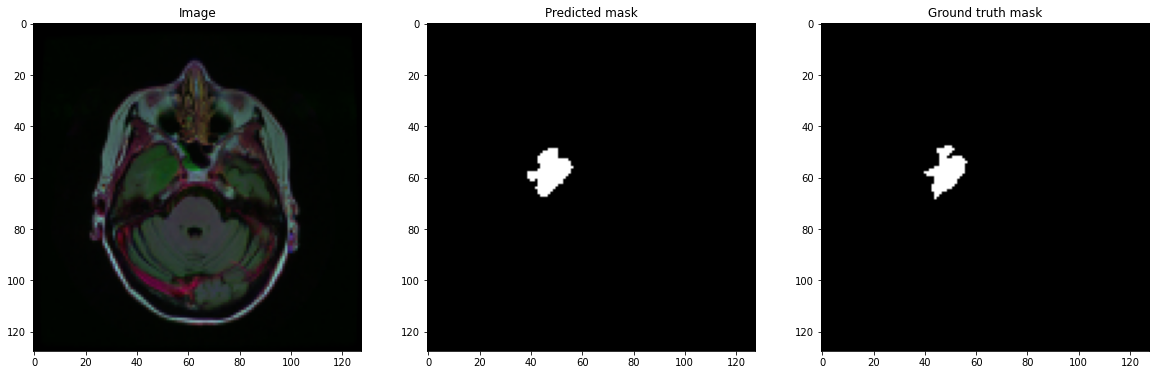

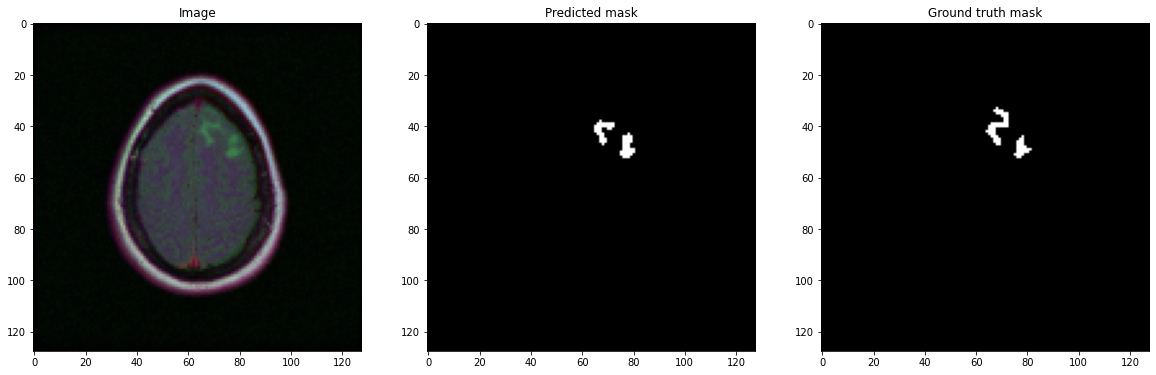

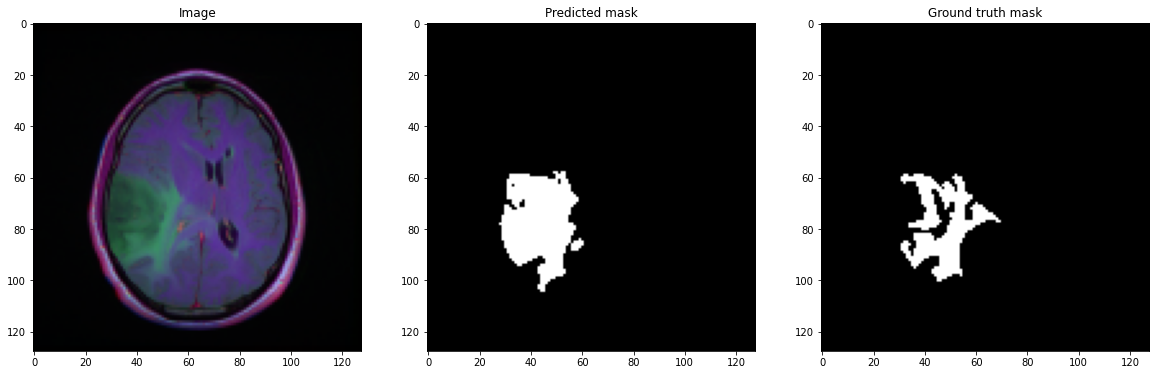

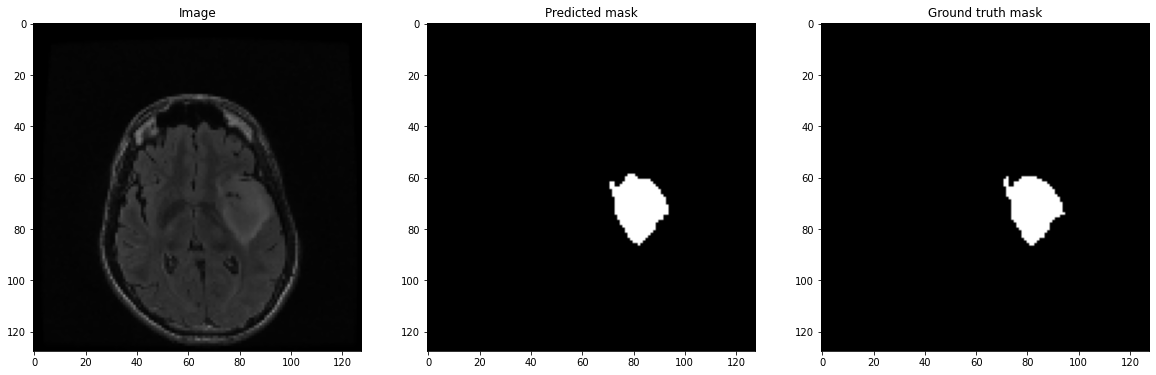

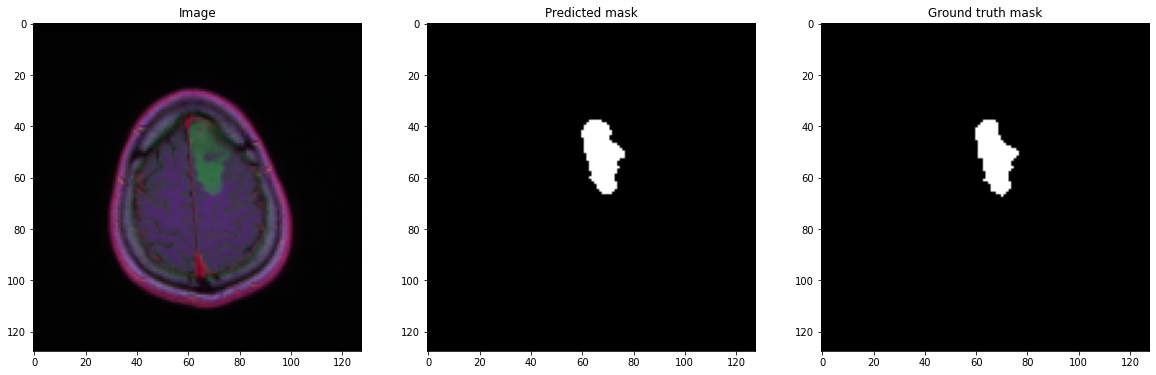

In [47]:
for idx in range(0, 5):
    plot_images(test_images[idx], predicted_masks[idx], ground_truth_masks[idx])